In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## Lifting Objects and Scenes from 2D to 3D with 3dfy

3dfy predicts object meshes and object positions in 3D given a 2D image with objects and an image mask that indicates the desired object. 


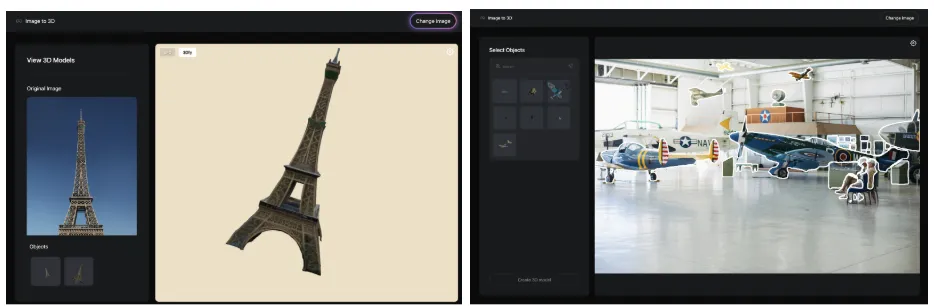

## System requirements
It is recommended to have at least 2 V100s (or GPUs with >30GB of storage) to prevent CUDA out of memory errors. Check below by running nvidia-smi.

## Set-up
Necessary imports and helper functions for displaying images and meshes.

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import os
import imageio
from IPython.display import Image as ImageDisplay

from inference import Inference, SceneVisualizer, ready_gaussian_for_video_rendering, render_video_ring, render_utils, get_gaussian_splatting_visualizer

In [ ]:
PATH = os.getcwd()
TAG = "hf" # "hf" or "public_v0"
config_path = f"{PATH}/../checkpoints/{TAG}/pipeline.yaml"
inference = Inference(config_path, compile=False)

## Load image to lift to 3D

SAM 3 lifts RGBA images to 3D meshes. You may use the provided example:

In [ ]:
IMAGE_PATH = f"{PATH}/images/cat.png"

Or find your own RGBA image.

In [ ]:
# Run this cell to copy an image at a url to the images folder.
url = "https://breed-assets.wisdompanel.com/cat/jungle-cat-felis-chaus/Jungle_Cat.png"
IMAGE_PATH=f"{PATH}/images/trellis.png"
os.environ['URL'] = url
os.environ['IMAGE_PATH'] = IMAGE_PATH

!curl "$URL" -o "$IMAGE_PATH"

The resulting image should have 4 channels (RGBA image) for this model to work on it. 
You can go to Google images and filter for transparent photos as a way to get RGBA images.

In [ ]:
IMAGE_NAME = os.path.splitext(os.path.basename(IMAGE_PATH))[0]

image = Image.open(IMAGE_PATH)
image = np.array(image)
image = image.astype(np.uint8)

print(image.shape, image.dtype, image.min(), image.max())
plt.imshow(image)

Now, everything is set up to generate the mesh for this 2D image. 

## Generate Mesh: Running All Steps at Once

Run the following cell to get the mesh for the 2D image. This image will be stored as a glb file at the meshes subfolder, titled sample2.glb.

In [ ]:
output = inference(image, seed=42)

# export gaussian splatting (as point cloud)
output["gs"].save_ply(f"{PATH}/gaussians/{IMAGE_NAME}.ply")

# export mesh
output["glb"].export(f"{PATH}/meshes/{IMAGE_NAME}.glb")

Now, you can visualize the gaussian splat.

In [ ]:
# render gaussian splat
scene_gs = ready_gaussian_for_video_rendering(output["gs"])
video = render_video_ring(
    scene_gs,
    r=2,
    fov=60,
)["color"]

# save video as gif
imageio.mimsave(
    os.path.join(f"{PATH}/gaussians/{IMAGE_NAME}.gif"),
    video,
    format="GIF",
    duration=1000 / 30,  # default assuming 30fps from the input MP4
    loop=0,  # 0 means loop indefinitely
)

# notebook display
ImageDisplay(url=f"gaussians/{IMAGE_NAME}.gif")

Congrats! you have now generated your first mesh using 3Dfy!

In [ ]:
from IPython.display import display

# interactive gaussian splat viewer (might be slow in some cases)
viz = get_gaussian_splatting_visualizer(scene_gs)
viz.show()